In [1]:
from gym.envs.registration import register
import gym
from envs.cluster_env import ClusterEnv
from envs.cluster_env import Job
from envs.cluster_env import Node
from envs.cluster_env import Action
import time

register(
    id='cluster-env-v0',
    entry_point='envs:ClusterEnv',
)

In [22]:
from torch import nn
import torch
import copy
import numpy as np
from torch import nn
from torch import optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [23]:
class MLP(nn.Module):

    def __init__(self, n, m):
        """
        n is the nuber of cores in a node.
        m is the number of jos we look at. (only look at first m jobs in the queue).
        It is not possible to consider the whole queue at once.
        
        input is size n + 2*m.
        Where the first n neurons encode the state of each core (how long they are occupied for).
        The last 2*m neurons are pairs of numbers (j_t, j_n).
        where j_t is number of time units job takes.
        and j_n is the nuber of cores the job takes.
        
        output of network is m logits indicating the which job to be scheduled.
        """
        super(MLP, self).__init__()
        
        # let's do two hidden layers
        self.layers = nn.Sequential(
            nn.Linear(n + 2*m, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, m),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [24]:
def nn_scheduler(env, model, state_vec):
    #if len(env.queue) == 0:
    #    return None
    
    node_index = 0
            
    input_vec = torch.tensor(state_vec).float()
    
    input_vec = input_vec.to(device)
    
    assert not bool(torch.isnan(input_vec).any())
    
    action_probs = model(input_vec.unsqueeze(0)).detach()
    
    # randomly choose one of the 8 jobs to schedule based on probabilities outputted by the network
    m = Categorical(action_probs)
    
    try:
        job_to_schedule = m.sample().to('cpu')
    except RuntimeError:
        print("action_probs: " , action_probs)
        raise RuntimeError
    #print(job_to_schedule)
    #return Action(0, node_index) # Uncomment to get SJF
    return Action(int(job_to_schedule), node_index)

def get_state(env):
    
    node_index = 0
    
    state_vec = copy.deepcopy(env.nodes[node_index].core_status)

    for job_index in range(min(len(env.queue), number_of_jobs_to_consider)):
        num_cores_required = env.queue[job_index].num_cores
        num_time_required = env.queue[job_index].num_timesteps
        state_vec.append(num_time_required)
        state_vec.append(num_cores_required)
        
    # pad with zeros if there are less than number_of_jobs_to_consider in the queue
    if len(env.queue) < number_of_jobs_to_consider:
        for _ in range(number_of_jobs_to_consider - len(env.queue)):
            state_vec.append(0)
            state_vec.append(0)
            
    return state_vec
    

In [28]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

In [29]:
def fifo(env):
    if len(env.queue) == 0:
        return None
    # always schedule first job

    for job_index in range(len(env.queue)):
        num_cores_required = env.queue[job_index].num_cores
        for node_index in range(len(env.nodes)):
            if env.nodes[node_index].num_avail_cores >= num_cores_required:
                # schedule first job on first available node
                return Action(0,node_index)
    return None

def run_simulation(scheduler, ep):
    '''
    Run simulation with scheduler function schuduler(env) -> Action.
    return loss.
    '''
    env = gym.make('cluster-env-v0')
    env.reset()

    # sort jobs in order from least time to most time
    def get_num_timesteps(job):
        return job.num_timesteps
    #env.queue.sort(key=get_num_timesteps, reverse=False)
    
    # store state, reward, action for every decision taken
    states = []
    rewards = []
    actions = []
    game_over = False
    
    batch_rewards = []
    batch_actions = []
    batch_states = []
    gamma=0.9 # TUNE for discounted reward
    max_wait = 20000 # stop episode when policy net diverged.
    
    # begin episode loop
    while not game_over and env.cumulative_wait_time < max_wait:
        valid_action = True

        while valid_action:
            # keep coming up with actions until we take an invalid action
         
            state_vec = get_state(env)
            
            action = nn_scheduler(env, model, state_vec)
            
            valid_action = env.take_action(action)
            
            ######### Reward. TUNE. #########
            reward = 0
            if not valid_action:
                reward = -len(env.queue)
            #################################
                
            states.append(state_vec)
            rewards.append(reward)
            actions.append(action.job_index)
            
        _, reward, game_over, _ = env.step()   # one step in time

        if game_over or env.cumulative_wait_time >= max_wait:
            #break  # Uncomment to get SJF
            
            batch_rewards.extend(discount_rewards(rewards, gamma))
            batch_states.extend(states)
            batch_actions.extend(actions)
            total_rewards.append(sum(rewards))
                
            optimizer.zero_grad()
            state_tensor = torch.FloatTensor(batch_states)
            reward_tensor = torch.FloatTensor(batch_rewards)
            # Actions are used as indices, must be LongTensor
            action_tensor = torch.LongTensor(batch_actions)

            state_tensor = state_tensor.to(device)
            reward_tensor = reward_tensor.to(device)
            action_tensor = action_tensor.to(device)
            
            assert not bool(torch.isnan(state_tensor).any())
            assert not bool(torch.isnan(reward_tensor).any())
            assert not bool(torch.isnan(action_tensor).any())
                    
            # Calculate loss
            logprob = torch.log(model(state_tensor))
            selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
            loss = -selected_logprobs.mean()
            
            nn.utils.clip_grad_norm_(model.parameters(),5.0)
                    
            # Calculate gradients
            loss.backward()
            # Apply gradients
            optimizer.step()
                    
            # Print running average
            print("\rEp: {} Average of last 10: {:.2f}".format(ep + 1, np.mean(total_rewards[-10:])), end="")

    #print(env.cumulative_wait_time)
    return env.cumulative_wait_time

In [32]:
sum_loss = 0
total_rewards = []
cum_wait_times = []

# Number of iterations to run the simulation for
num_iters = 100
device = 'cpu'
number_of_jobs_to_consider = 64 # SAME AS SIMULATION
number_of_cores = 32 # SAME AS SIMULATION
model = MLP(number_of_cores, number_of_jobs_to_consider)
model = model.to(device)

# TUNE
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

for i in range(num_iters):
    cumulative_wait_time = run_simulation(fifo, i)
    cum_wait_times.append(cumulative_wait_time)

Ep: 100 Average of last 10: -13661.70

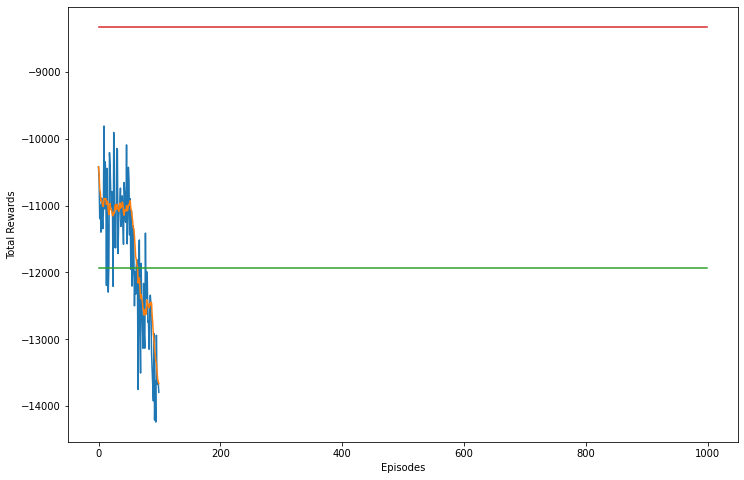

In [33]:
window = 10
smoothed_rewards = [np.mean(total_rewards[i-window:i+1]) if i > window 
                    else np.mean(total_rewards[:i+1]) for i in range(len(total_rewards))]

plt.figure(figsize=(12,8))
plt.plot(total_rewards)
plt.plot(smoothed_rewards)
plt.plot([-11934]*1000)
plt.plot([-8322]*1000)
#plt.plot(cum_wait_times)
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')
plt.show()